# Simple Neural Network Model with different number of months

Input: testing different number of months in input using single PCA

Output: optimal max-shape portfolio with loose restrictions for the next period

## Data Pre-processing

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.regularizers import L2

from helper_functions import train_and_evaluate_model, calculate_returns_for_model, calculate_metrics

In [15]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [16]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

In [17]:
days_to_recalculate = data_provider.get_days_to_recalculate()

# Start after 1 year to have enough historic data for first calculated period
days_to_recalculate = days_to_recalculate.iloc[12:]
days_to_recalculate = pd.DatetimeIndex(days_to_recalculate)
days_to_recalculate

DatetimeIndex(['2000-01-04', '2000-02-04', '2000-03-06', '2000-04-04',
               '2000-05-04', '2000-06-06', '2000-07-05', '2000-08-04',
               '2000-09-06', '2000-10-04',
               ...
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023-10-05',
               '2023-11-03', '2023-12-05'],
              dtype='datetime64[ns]', name='Days to rebalance', length=288, freq=None)

Preparing outputs common for all models

In [18]:
os.chdir(os.path.expanduser('../optimization'))

from PortfolioOptimizer import PortfolioOptimizer

In [19]:
y = []
for i in range(0,len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    try:
        optimizer = PortfolioOptimizer()
        w, constraints = optimizer.get_loose_constraints(acwi_weights_year)
        optimal_portfolio = optimizer.get_optimal_portfolio(
            data_period, w, constraints)
    except:        
        summed_weight = acwi_weights_year.sum(axis=1)
        scaled_acwi_weights = acwi_weights_year.iloc[0] / summed_weight.values[0]
        optimal_portfolio = scaled_acwi_weights.round(3)
        print('Cannot get optimal portfolio for', days_to_recalculate[i])

    y.append(optimal_portfolio.values)

y = np.array(y)
y.shape

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cannot get optimal portfolio for 2022-08-03 00:00:00


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cannot get optimal portfolio for 2023-05-04 00:00:00
Cannot get optimal portfolio for 2023-07-06 00:00:00
Cannot get optimal portfolio for 2023-12-05 00:00:00


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(288, 27)

In [20]:
val_split = int(0.7 * y.shape[0])
test_split = int(0.8 * y.shape[0])

# Train
dates_for_training = days_to_recalculate[:val_split]
y_train = y[:val_split]

# Validation
dates_for_validation = days_to_recalculate[val_split:test_split]
y_val = y[val_split:test_split]

# Test
dates_for_test = days_to_recalculate[test_split:]
y_test = y[test_split:]

In [21]:
os.chdir(os.path.expanduser('../data'))

In [22]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [23]:
selected_countries = df_countries.columns
days_to_rebalance = dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

## Defining models for different number of months

In [24]:
total_ret_list = []
cum_total_ret_list = []

for no_months in range(3, 10):
    print(f'DNN Model for {no_months} months')
    x = []
    for date in days_to_recalculate:
        indicators = data_provider.calculate_principal_component_from_indicators(
            date, periods=no_months, indicators=all_indicators)
        x.append(indicators.values)

    x_pca = np.array(x)
    x_train = x_pca[:val_split]
    x_val = x_pca[val_split:test_split]
    x_test = x_pca[test_split:]

    model_dnn = Sequential((
        Flatten(input_shape=x_train.shape[1:]),
        Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
        Dense(y_train.shape[1], activation='softmax')
    ))

    train_and_evaluate_model(model_dnn, x_train, y_train,
                             x_val, y_val, x_test, y_test,
                             verbose=False)

    (total_ret, cum_total_ret) = calculate_returns_for_model(
        model_dnn, x_test, dates_for_test,
        df_returns_test, selected_countries)

    total_ret_list.append(total_ret)
    cum_total_ret_list.append(cum_total_ret)

DNN Model for 3 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train error: 0.021239249035716057
Val error: 0.021922364830970764
Test error: 0.02609163336455822
Execution time 8.22 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
DNN Model for 4 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train error: 0.02124924026429653
Val error: 0.02191571332514286
Test error: 0.02616753987967968
Execution time 8.19 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
DNN Model for 5 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train error: 0.021264294162392616
Val error: 0.021923381835222244
Test error: 0.026240944862365723
Execution time 8.17 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
DNN Model for 6 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train error: 0.021205957978963852
Val error: 0.02192438207566738
Test error: 0.026227779686450958
Execution time 8.27 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
DNN Model for 7 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train error: 0.021200567483901978
Val error: 0.021828124299645424
Test error: 0.0261884443461895
Execution time 8.23 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
DNN Model for 8 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train error: 0.02119005285203457
Val error: 0.021722938865423203
Test error: 0.026373405009508133
Execution time 8.37 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
DNN Model for 9 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train error: 0.021172234788537025
Val error: 0.021776601672172546
Test error: 0.026381656527519226
Execution time 8.15 seconds
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


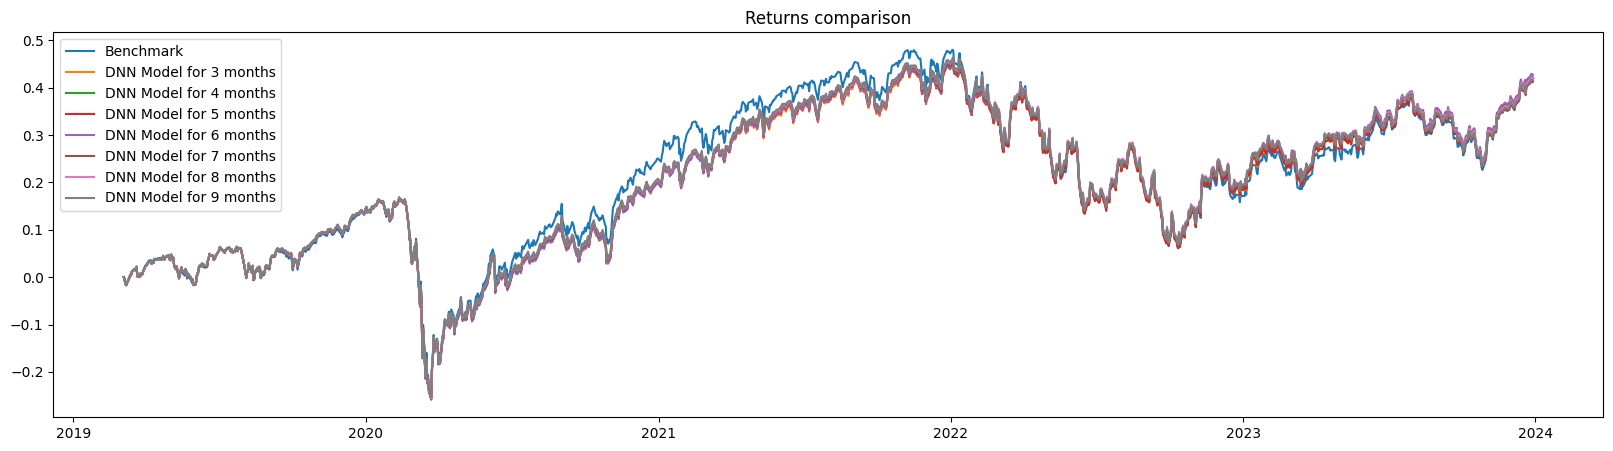

In [25]:
plt.figure(figsize=(20, 5))
plt.plot(cum_benchmark_returns, label='Benchmark')

for no_months in range(7):
    plt.plot(cum_total_ret_list[no_months],
             label=f'DNN Model for {no_months+3} months')

plt.legend()
plt.title('Returns comparison')
plt.show()

In [26]:
df_results = pd.DataFrame(columns=['Annual Returns',
                                   'Annual Volatility',
                                   'Annual Sharpe Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')

for no_months in range(7):
    calculate_metrics(total_ret_list[no_months], df_results,
                      f'DNN Model for {no_months+3} months')

df_results

,Annual Returns,Annual Volatility,Annual Sharpe Ratio
Benchmark,0.076754,0.203326,0.377494
DNN Model for 3 months,0.075384,0.200288,0.376376
DNN Model for 4 months,0.075514,0.199747,0.37805
DNN Model for 5 months,0.074269,0.199678,0.371945
DNN Model for 6 months,0.076572,0.199943,0.382971
DNN Model for 7 months,0.075479,0.199637,0.378079
DNN Model for 8 months,0.07539,0.199809,0.377311
DNN Model for 9 months,0.074684,0.199902,0.373603
